In [1]:
import yfinance as yf
import matplotlib as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import math
from datetime import date

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras import optimizers

from ipywidgets import IntProgress

Using TensorFlow backend.


In [2]:
tick = yf.Ticker("KO")
stock = tick.history(period='max')
#Only use 4 years of data
today = date.today()
formed_date = today.strftime("%Y-%m-%d")
stock = stock.loc['2017-10-01':formed_date]
stock.tail()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-11-26,52.914744,53.540071,52.825411,53.500370,13219800.0,0.0,0.0
2019-11-27,53.530147,53.698885,53.202592,53.549999,9595200.0,0.0,0.0
2019-11-29,53.700001,53.730000,53.220001,53.400002,7222300.0,0.4,0.0
2019-12-02,53.320000,53.750000,52.849998,53.750000,13173800.0,0.0,0.0
2019-12-03,53.709999,53.830002,53.400002,53.595001,5234798.0,0.0,0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


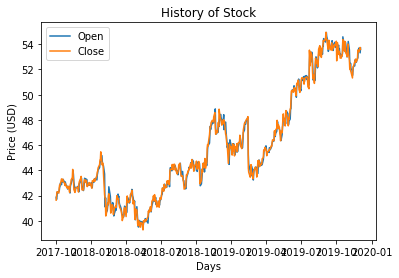

In [3]:
plt.figure()
plt.plot(stock["Open"])
plt.plot(stock["Close"])
plt.title('History of Stock')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'Volume'], loc='upper left')
plt.show()

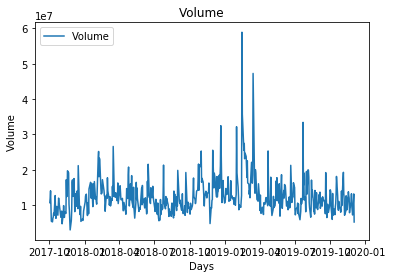

In [4]:
plt.figure()
plt.plot(stock["Volume"])
plt.title('Volume')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['Volume'], loc='upper left')
plt.show()

In [5]:
#Features
train_cols = ['Open', 'High', 'Close', 'Low', 'Volume']
#Make training set 80% of the data
vti_train, vti_test = train_test_split(stock, train_size=0.8, test_size=0.2, shuffle=False)
x = vti_train.loc[:,train_cols].values
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x)
x_test = scaler.fit_transform(stock.loc[:,train_cols])
print(x[:1])
print(x_train[:1])

[[4.18633816e+01 4.20678210e+01 4.16310654e+01 4.15846028e+01
  1.07078000e+07]]
[[0.20465185 0.20708958 0.19848244 0.20462854 0.13792925]]


In [6]:
#How many days in the past that we want to look at
TIME_STEPS = 5

def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS + i]
        y[i] = mat[TIME_STEPS + i, y_col_index]
    print("Length of time-series i/o", x.shape, y.shape)
    return x, y

def trim_data(mat, batch_size):
    num_rows_dropped = mat.shape[0]%batch_size
    if(num_rows_dropped > 0):
        return mat[:-num_rows_dropped]
    else:
        return mat

In [7]:
BATCH_SIZE = 2

x_t, y_t = build_timeseries(x_train, 3)
print(x_t.shape)
x_t = trim_data(x_t, BATCH_SIZE)
print(x_t.shape)
y_t = trim_data(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_data(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_data(y_temp, BATCH_SIZE), 2)
print(x_test_t.shape)



Length of time-series i/o (432, 5, 5) (432,)
(432, 5, 5)
(432, 5, 5)



Length of time-series i/o (542, 5, 5) (542,)
(271, 5, 5)


In [33]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0,
              recurrent_dropout=0.1, stateful=True, kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam') 
vti_history = model.fit(x_t, y_t, epochs=45, verbose=2, 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        validation_data=(trim_data(x_val, BATCH_SIZE), trim_data(y_val, BATCH_SIZE)))

Train on 432 samples, validate on 270 samples
Epoch 1/45
 - 2s - loss: 0.0261 - val_loss: 0.1767
Epoch 2/45
 - 1s - loss: 0.0305 - val_loss: 0.2252
Epoch 3/45
 - 1s - loss: 0.0361 - val_loss: 0.2175
Epoch 4/45
 - 1s - loss: 0.0404 - val_loss: 0.2139
Epoch 5/45
 - 1s - loss: 0.0373 - val_loss: 0.1381
Epoch 6/45
 - 1s - loss: 0.0280 - val_loss: 0.1725
Epoch 7/45
 - 1s - loss: 0.0254 - val_loss: 0.1915
Epoch 8/45
 - 1s - loss: 0.0260 - val_loss: 0.0796
Epoch 9/45
 - 1s - loss: 0.0156 - val_loss: 0.0512
Epoch 10/45
 - 1s - loss: 0.0117 - val_loss: 0.0360
Epoch 11/45
 - 1s - loss: 0.0102 - val_loss: 0.0315
Epoch 12/45
 - 1s - loss: 0.0090 - val_loss: 0.0289
Epoch 13/45
 - 1s - loss: 0.0078 - val_loss: 0.0180
Epoch 14/45
 - 1s - loss: 0.0060 - val_loss: 0.0154
Epoch 15/45
 - 1s - loss: 0.0057 - val_loss: 0.0137
Epoch 16/45
 - 1s - loss: 0.0049 - val_loss: 0.0127
Epoch 17/45
 - 1s - loss: 0.0051 - val_loss: 0.0144
Epoch 18/45
 - 1s - loss: 0.0049 - val_loss: 0.0152
Epoch 19/45
 - 1s - loss: 0

In [34]:
y_pred = model.predict(trim_data(x_test_t, BATCH_SIZE), batch_size= BATCH_SIZE)
print(x_test_t.shape)
y_pred - y_pred.flatten()
y_test_t = trim_data(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is ", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

(271, 5, 5)
Error is  0.0019754808165811932 (270, 1) (270,)
[[0.4582965 ]
 [0.49475393]
 [0.5396164 ]
 [0.57777333]
 [0.57721925]
 [0.58147764]
 [0.6038792 ]
 [0.6003313 ]
 [0.59853643]
 [0.58872783]
 [0.6005845 ]
 [0.6416317 ]
 [0.6165658 ]
 [0.5344118 ]
 [0.5297193 ]]
[0.4510096  0.49370973 0.52071091 0.52510626 0.54143289 0.55273588
 0.55524733 0.55587553 0.53578138 0.55838717 0.59731896 0.5320139
 0.49308165 0.49056984 0.49810483]


In [35]:
#3 being the amount of y_cols
y_pred_org = (y_pred * scaler.data_range_[3] + scaler.data_min_[3])
y_test_org_t = (y_test_t * scaler.data_range_[3] + scaler.data_min_[3])

print(y_pred_org.shape)
print(y_test_org_t.shape)

(270, 1)
(270,)


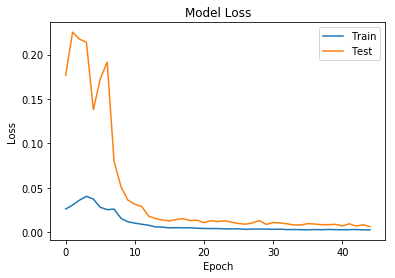

In [36]:
plt.figure()
plt.plot(vti_history.history['loss'])
plt.plot(vti_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])

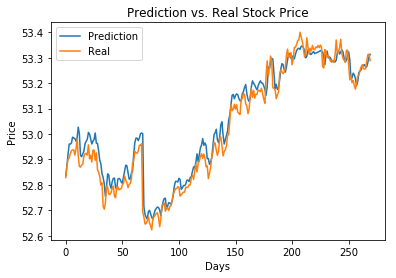

In [37]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_org_t)
plt.title('Prediction vs. Real Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(['Prediction', 'Real'])
plt.savefig("charts/XXIIStock.png")
plt.show()

In [38]:
next_pred = stock[-7:]
#Features
train_cols = ['Open', 'High', 'Close', 'Low', 'Volume']
x_pred_values = next_pred.loc[:,train_cols].values
predx = scaler.fit_transform(x_pred_values)
x_fut, y_fut = build_timeseries(predx, 3)

y_test_t = trim_data(y_test_t, BATCH_SIZE)

future_pred = model.predict(trim_data(x_fut, BATCH_SIZE), batch_size= BATCH_SIZE)

future_pred - future_pred.flatten()
y_fut = trim_data(y_fut, BATCH_SIZE)

fut_pred_org = (future_pred * scaler.data_range_[3] + scaler.data_min_[3])
y_fut = (y_fut * scaler.data_range_[3] + scaler.data_min_[3])

print(next_pred)
print(y_fut)
print(fut_pred_org)
fut_pred_org[0][-1]


Length of time-series i/o (2, 5, 5) (2,)
                 Open       High        Low      Close      Volume  Dividends  \
Date                                                                            
2019-11-22  52.567337  52.795631  52.358895  52.636818   9113300.0        0.0   
2019-11-25  52.884965  52.994151  52.378748  52.825413  10963500.0        0.0   
2019-11-26  52.914744  53.540071  52.825411  53.500370  13219800.0        0.0   
2019-11-27  53.530147  53.698885  53.202592  53.549999   9595200.0        0.0   
2019-11-29  53.700001  53.730000  53.220001  53.400002   7222300.0        0.4   
2019-12-02  53.320000  53.750000  52.849998  53.750000  13173800.0        0.0   
2019-12-03  53.709999  53.830002  53.400002  53.595001   5234798.0        0.0   

            Stock Splits  
Date                      
2019-11-22           0.0  
2019-11-25           0.0  
2019-11-26           0.0  
2019-11-27           0.0  
2019-11-29           0.0  
2019-12-02           0.0  
2019-12-03  

53.233562